## A First Look at the Data
The dataset we'll be using is called `MovieLens`. This dataset contains tens of millions of movie rankings, although we will just use a subset of 100k of them for our example.

In [ ]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

The data is not separated by commas but by `tabs` we can parse `\t` as a delimiter so we can read the data

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Although this has all the information we need, it is not a particularly helpful way to look at this data. Below table shows the same data cross-tabulated into a human-friendly form.\
![image](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff/images/att_00040.png) \
The empty cells in this table are the things that we would like our model to learn to fill in (`predict`). Those are the places where a user has not reviewed the movie yet, presumably because they have not watched it. For each user, we would like to figure out which of those movies they might be most likely to enjoy.

We can do that by representing a movie as a tensor of numbers.\
For example we could represent the movie `The Last Skywalker` as ...

In [ ]:
last_skywalker = np.array([0.98,0.9,-0.9])

We are scoring `0.98` as very science-fiction movie, `0.9` very action movie, and `-0.9` as not an old movie. We could represent a user who likes modern sci-fi action movies as:

In [ ]:
user1 = np.array([0.9,0.8,-0.6])

And now if we multiply user by a movie and then sum up the numbers, so we can see the `score` if it's high we can predict that the user would like the movie, and if it's low (negative) we predict that the user wouldn't like the movie

In [ ]:
(user1*last_skywalker).sum()

2.1420000000000003

In [ ]:
casablanca = np.array([-0.99,-0.3,0.8])

In [ ]:
(user1*casablanca).sum()

-1.611

## Creating the DataLoaders

When showing the data, we would rather see movie titles than their IDs. The table `u.item` contains the correspondence of IDs to titles:

In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


We can merge this with our ratings table to get the user ratings by title as well.

In [ ]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


We can build a `DataLoaders` object using fastai liblary. By default, it takes the first column as the user, and the second column for the item (Here it is our movie), and the third column for the ratings. We need to change the value of `item_name` in our case to use the titles instead of the IDs:

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,92,Lawnmower Man 2: Beyond Cyberspace (1996),1
1,16,Stand by Me (1986),5
2,1,Quiz Show (1994),4
3,686,Duck Soup (1933),4
4,529,In & Out (1997),4
5,838,"Mask, The (1994)",4
6,680,"Wrong Trousers, The (1993)",5
7,682,"Sex, Lies, and Videotape (1989)",3
8,294,Ransom (1996),4
9,906,Heat (1995),4


In [ ]:
dls.classes['user'][:10],dls.classes['title'][:10]

((#10) ['#na#',1,2,3,4,5,6,7,8,9],
 (#10) ['#na#',"'Til There Was You (1997)",'1-900 (1994)','101 Dalmatians (1996)','12 Angry Men (1957)','187 (1997)','2 Days in the Valley (1996)','20,000 Leagues Under the Sea (1954)','2001: A Space Odyssey (1968)','3 Ninjas: High Noon At Mega Mountain (1998)'])

Creating latent factors for the user and the movie.

In [ ]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

To calculate the result for a particular movie and user combination, we have to look up the index of the movie in our movie latent factor matrix and the index of the user in our user latent factor matrix; then we can do our dot product between the two latent factor vectors. But look up in an index is not an operation our deep learning models know how to do. They know how to do matrix products, and activation functions.

Fortunately, it turns out that we can represent look up in an index as a matrix product. The trick is to replace our indices with one-hot-encoded vectors. Here is an example of what happens if we multiply a vector by a one-hot-encoded vector representing the index 3:

In [ ]:
one_hot_3 = one_hot(3, n_users).float()

In [ ]:
user_factors.t() @ one_hot_3

tensor([ 1.6976,  0.1139,  0.0346,  0.4224, -0.1760])

It gives us the same vector as the one at index 3 in the matrix:

In [ ]:
user_factors[3]

tensor([ 1.6976,  0.1139,  0.0346,  0.4224, -0.1760])

## Collaborative Filtering from Scratch

Note that creating a new PyTorch module requires inheriting from `Module`.
The thing that we need to know to create a new PyTorch module is that when our module is called. PyTorch will call a method in our call called `forward`, and will pass along to that any parameters that are included in the call.

In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

Note that the input of the model is a tensor of shape `batch_size x 2`, where the first column (`x[:, 0]`) contains the user IDs and the second column (`x[:, 1]`) contains the movie IDs. As explained before, we use the embedding layers to represent our matrices of user and movie latent factors:

In [ ]:
x,y = dls.one_batch()
x.shape, x[:5],"User IDs", x[:,0][:5],"Movie IDs", x[:,1][:5]

(torch.Size([64, 2]),
 tensor([[ 807,  255],
         [ 881,  581],
         [  58, 1417],
         [  94, 1029],
         [ 514,  274]]),
 'User IDs',
 tensor([807, 881,  58,  94, 514]),
 'Movie IDs',
 tensor([ 255,  581, 1417, 1029,  274]))

Now that we have defined our architecture, and created our parameters matrices, we need to create `Learner`.

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

We are now ready to train our model:

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.341441,1.300256,00:09
1,1.097734,1.077599,00:10
2,0.939855,0.981324,00:09
3,0.841633,0.878749,00:08
4,0.783042,0.865914,00:09


The first thing we can do to make our model a little bit better is to force prediction to be between 0 and 5. For this, we can use already know `sigmoid`. One thing we is that it's better to have the range go a little bit over 5, since sigmoid never reaches maximum value, so we will used `(0, 5.5)`

In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

And let's train again:

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.995753,0.993011,00:09
1,0.904139,0.900687,00:11
2,0.659721,0.867739,00:09
3,0.494031,0.873210,00:10
4,0.363530,0.878632,00:12


Looks a lot better, but we can do even better. One obvious missing thing is that some users are just more positive or negative in their recommendations than others, and some movies are just better or worse than others. But in our calculations we do not have any way to encode either of these things. \

We can add a single number for each user that we can add to our scores, and ditto for each movie, that will handle this missing piece very nicely. This single number is called `bias`.

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

Lets train our model:

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.939353,0.929019,00:11
1,0.820720,0.854279,00:09
2,0.601930,0.859065,00:13
3,0.392151,0.886714,00:10
4,0.280966,0.893484,00:09


Our `training_loss` goes down, but our `valid_loss` goes up at the end, this is a clear indication of overfitting. In this case, there is no way to use data augmentation, so we will have to use another regularization technique. One approach that can be helpful is `weight dacay`.

### Weight Decay

Weight decay, or L2 regularization, consist in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

Why would it prevent overfitting? The idea is that the larger the coefficients are, the sharper canyons we will have in the loss function. If we take the basic example of a `y = a * x**2`, the larger `a` is, the more narrow the parabola is.

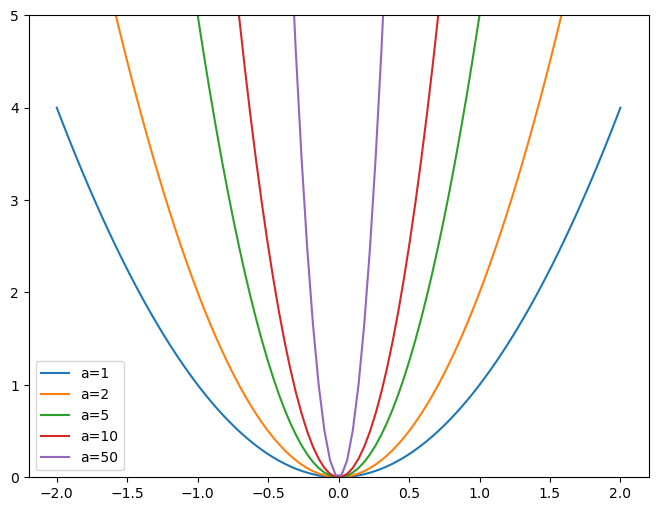

In [ ]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

Weight decay or just `wd` is a parameter that controls that sum of squares we add to our loss.
> `loss_with_wd = loss + wd * parameters**2.sum()`

In practice, though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. We can just calculate the derivative of `parameters**2` which is equal to `2 * p`, so adding the big sum to our loss is exactly the same as doing:
> `loss_with_wd = wd * 2 * parameters`

Since `wd` is a parameter that we choose, we can just make it twice as big, so we don't even need `*2` part.

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.928787,0.949326,00:09
1,0.864657,0.881492,00:09
2,0.749078,0.829044,00:09
3,0.578540,0.819058,00:09
4,0.481202,0.819370,00:09


And as expected, we don't overfit!

### Creating Our Own Embedding Module

So far, we've used `Embedding` without thinking about how it really works. Let's re-create `DotProductBias` without using this class. \
We have to be careful, since optimizers require that they can get all the parameters of a module from the module's `parameters` method. However, this does not happen fully automatically. If we just add a tensor as an attribute to a `Modeul`, it will not include `parameters`.

In [ ]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

To tell the `Modeul` that we need a tensor as a parameter, we need to wrap it in `nn.Parameter` class. This class doesn't actually add any functionality (other than automatically calling `requires_grad_`. It's only used as a "marker" to show what to include in `parameters`.

In [ ]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

All pytorch modules use `nn.Parameters` for any trainable parameters.

In [ ]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[0.2044],
        [0.8197],
        [0.2877]], requires_grad=True)]

In [ ]:
type(t.a.weight)

torch.nn.parameter.Parameter

We can create a tensor as a parameter, with random init.

In [ ]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [ ]:
create_params(tensor([3]))

Parameter containing:
tensor([ 0.0009,  0.0076, -0.0064], requires_grad=True)

Let's use this to create `DotProductBias` again, but without the `Embedding`.

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

And let's train:

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.920867,0.952832,00:13
1,0.833844,0.863312,00:10
2,0.742645,0.830492,00:13
3,0.589977,0.823320,00:13
4,0.463834,0.822690,00:12


Our `Embeding` works. \
Now, let's take a look at what our model has learned.

## Interpreting Embeddings and Biases

It is interesting to see what parameters it has discovered. The easiest to interpret are the biases. Here are the movies withe lowest values in the bias vector.

In [ ]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Robocop 3 (1993)',
 'Amityville II: The Possession (1982)',
 'Jury Duty (1995)']

Lowest bias value means that, even when a user is very well matched to its latent factors, they still generally don't like it. \
Now let's look at the movies with the highest values 

In [ ]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 "Schindler's List (1993)",
 'L.A. Confidential (1997)',
 'Star Wars (1977)']

It is not quite so easy to directly interpret the embedding matrix. There are just too many factors for a human to look at. But there is a technique that can pull the most important underlying directions in such a matrix. called ` principal component analysisc` **`PCA`**.

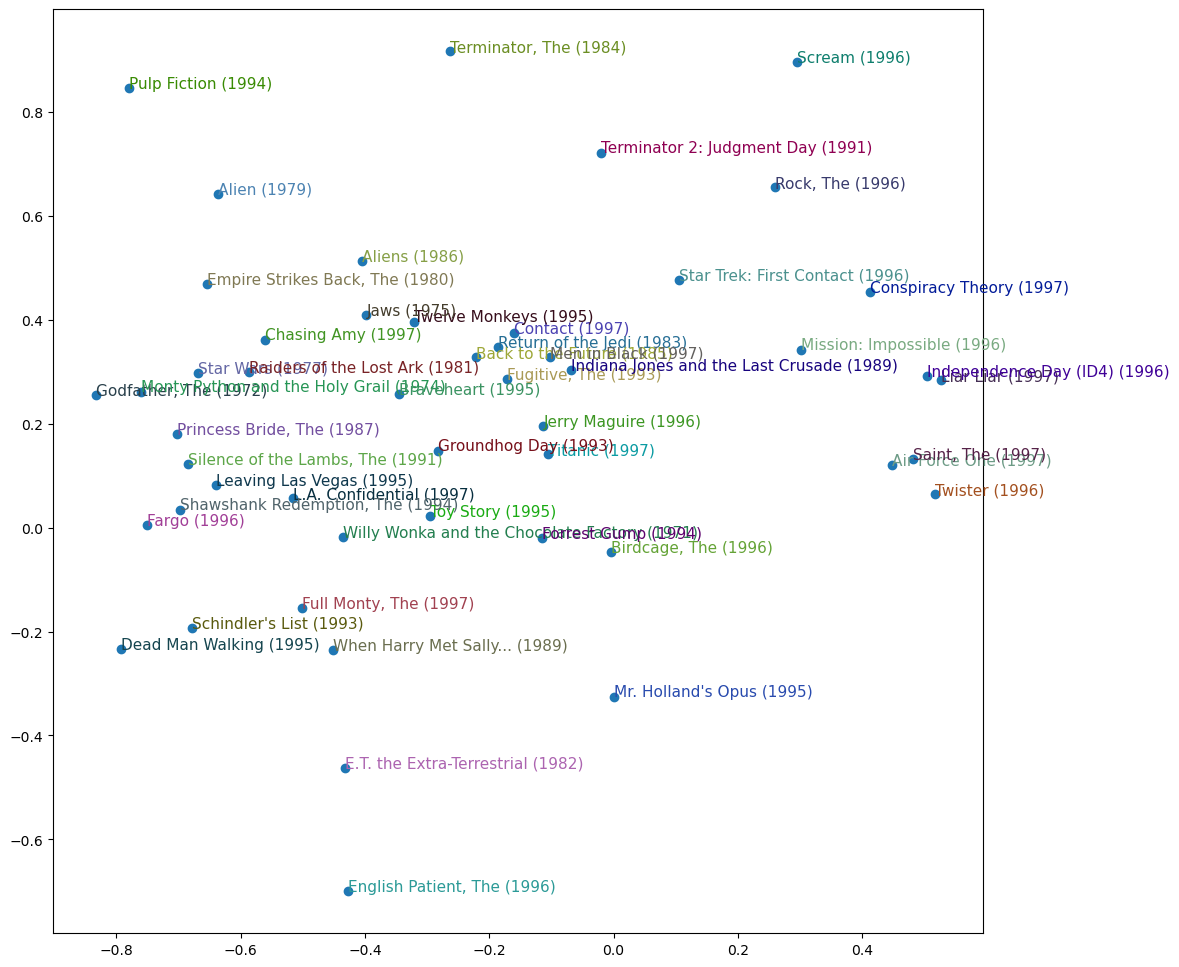

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

We can see here that the model seems to have discovered some sort of concept.

>Jeremy: No matter how many models I train, I never stop getting moved and surprised by how these randomly initialized bunches of numbers, trained with such simple mechanics, manage to discover things about my data all by themselves. It almost seems like cheating, that I can create code that does useful things without ever actually telling it how to do those things!

### Using fastai.collab

We can create and train a collaborative filtering model using the exact strucutre shown earlier by using fastai's `collab_learner`

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.918921,0.946220,00:11
1,0.877677,0.871620,00:11
2,0.749717,0.833303,00:12
3,0.576543,0.822094,00:10
4,0.510695,0.821848,00:09


The names of the layers can be seen by printing the model:

In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

We can use these to replicate any of the analyses we did in the previous section.

In [ ]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 'Star Wars (1977)',
 "Schindler's List (1993)",
 'Silence of the Lambs, The (1991)']

### Embedding Distance

On a two-dimensional map we can calculate the distance between two coordinates using the `sqrt(x^2+y^2)`. For a 50-dimensional embedding, we can do exactly the same thing, except that we add up the squares of all 50 of the coordinate distances. \
We can use this to find the most similar movie to `Silence of the Lambs`.

In [ ]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Stand by Me (1986)'

## Deep Learning for Collaborative Filtering

fastai has a function `get_emb_sz` that return recommended sizes for embedding matrices for your data, based on heuristic that fast.ai has found tends to work well in practice.

In [ ]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [ ]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [ ]:
model = CollabNN(*embs)

`CollabNN` creates our `Embedding` layers in the same way as previous classes in this chapter, except that we now use the `embs` sizes.

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.918357,0.946983,00:12
1,0.918140,0.914214,00:14
2,0.833999,0.871329,00:12
3,0.840610,0.859441,00:13
4,0.752391,0.859842,00:14


fastai provides this model in `fastai.collab` if u pass `use_nn = True` in your call to `collab_learner` and lets you easily create more layers. For instance, here we're creating two hidden layers,, of size 100 and 50, respectively.

In [ ]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.984000,0.979401,00:16
1,0.960109,0.911486,00:15
2,0.901726,0.880157,00:15
3,0.840057,0.853600,00:13
4,0.769136,0.854030,00:14


`learn.model` is an object of type `EmbeddingNN`. Let's look at the code for this class.

In [ ]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

This class inherits from `TabularModel`, which is where it gets all its functionality from. In `__init__` it calls the same method in TabularModel, passing `n_cont=0` and `out_sz=1;` other than that, it only passes along whatever arguments it received.

### End sidebar

Although the results of `EmbeddingNN` are a bit worse than the dot product approach (which shows the power of carefully constructing an architecture for a domain), it does allow us to do something very important: we can now directly incorporate other user and movie information, date and time information, or any other information that may be relevant to the recommendation. That's exactly what `TabularModel` does. In fact, we've now seen that `EmbeddingNN` is just a `TabularModel`, with `n_cont=0` and `out_sz=1.` So, we'd better spend some time learning about `TabularModel`, and how to use it to get great results! We'll do that in the next chapter.

### Further Research

1. Take a look at all the differences between the `Embedding` version of `DotProductBias` and the `create_params` version, and try to understand why each of those changes is required. If you're not sure, try reverting each change to see what happens. (NB: even the type of brackets used in `forward` has changed!)
1. Find three other areas where collaborative filtering is being used, and find out what the pros and cons of this approach are in those areas.
1. Complete this notebook using the full MovieLens dataset, and compare your results to online benchmarks. See if you can improve your accuracy. Look on the book's website and the fast.ai forum for ideas. Note that there are more columns in the full dataset—see if you can use those too (the next chapter might give you ideas).
1. Create a model for MovieLens that works with cross-entropy loss, and compare it to the model in this chapter.